Jonnatan Arias Garcia

jonnatan.arias@utp.edu.co

jariasg@uniquindio.edu.co

Recurso Oficial:
https://petar-v.com/GAT/

# Imports & Utils

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Sistema Base (A Pedal)

## Transformación Lineal

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
Con $\textbf{W}\in\mathbb R^{F'\times F}$ y $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [ ]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features)


# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


## Mecanismo de Atención
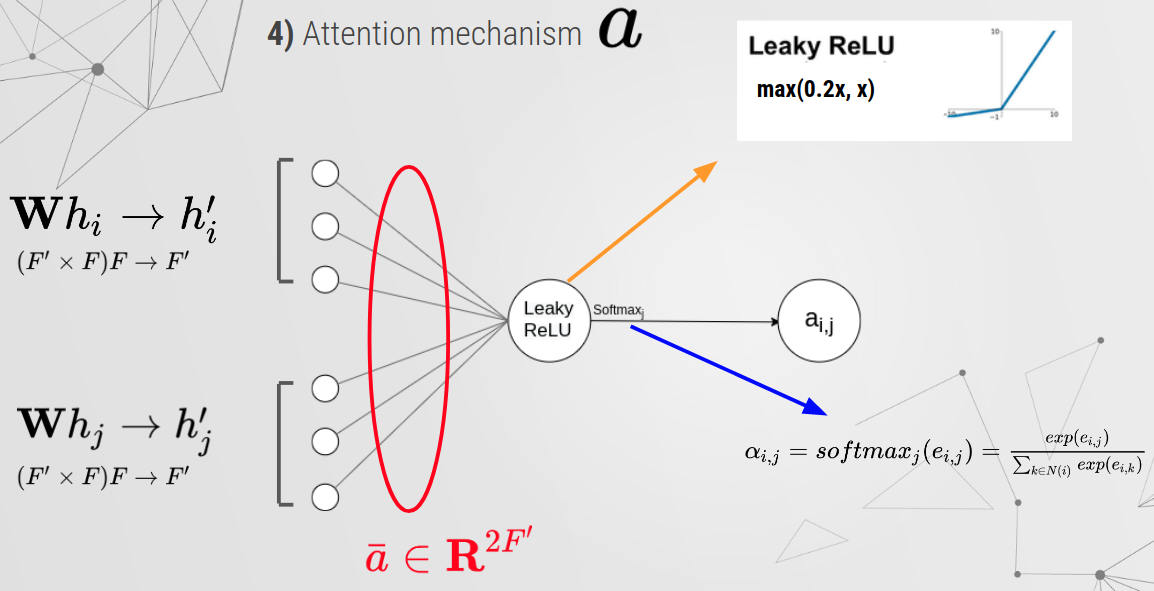

In [ ]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier paramiter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


In [ ]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)

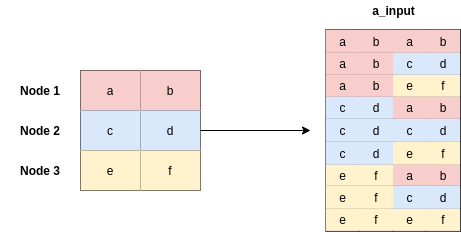

In [ ]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [ ]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


## Attention

In [ ]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)

torch.Size([3, 3])


In [ ]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[0, 0, 1],
        [1, 0, 1],
        [1, 0, 0]]) 
 tensor([[2.0145, 1.5005, 2.4130],
        [1.6275, 1.1134, 2.0259],
        [1.4774, 0.9633, 1.8758]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-9.0000e+15, -9.0000e+15,  2.4130e+00],
        [ 1.6275e+00, -9.0000e+15,  2.0259e+00],
        [ 1.4774e+00, -9.0000e+15, -9.0000e+15]], grad_fn=<WhereBackward0>)

In [ ]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [ ]:
attention

tensor([[0.0000, 0.0000, 1.0000],
        [0.4017, 0.0000, 0.5983],
        [1.0000, 0.0000, 0.0000]], grad_fn=<SoftmaxBackward0>)

In [ ]:
h_prime

tensor([[-1.7105,  0.3635],
        [-1.7656,  0.1845],
        [-1.8477, -0.0822]], grad_fn=<MmBackward0>)

### h' Vs. h

In [ ]:
print(h_prime,"\n",h)

tensor([[-1.7105,  0.3635],
        [-1.7656,  0.1845],
        [-1.8477, -0.0822]], grad_fn=<MmBackward0>) 
 tensor([[-1.8477, -0.0822],
        [-1.0311, -0.4858],
        [-1.7105,  0.3635]], grad_fn=<MmBackward0>)


## Construyendo la capa

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()

        '''
        TODO
        '''

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    #
        self.out_features  = out_features   #
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.


        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)

        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Ejemplo de Uso (tambien con Pytorch)

## Cora

https://graphsandnetworks.com/the-cora-dataset/

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Processing...
Done!


In [ ]:
'''
dataset = Planetoid('./', 'Cora')
data = dataset[0]

x = data.x
y = data.y
edge_index = data.edge_index
train_mask = data.train_mask
val_mask = data.val_mask
test_mask = data.test_mask

y_train = y[train_mask]
y_val = y[val_mask]
y_test = y[test_mask]

train_index = torch.arange(0, 140)
val_index = torch.arange(140, 640)
test_index = torch.arange(1708, 2708)

y_train = torch.cat((train_index.reshape(-1, 1), y_train.reshape(-1, 1)), dim=1)
y_val = torch.cat((val_index.reshape(-1, 1), y_val.reshape(-1, 1)), dim=1)
y_test = torch.cat((test_index.reshape(-1, 1), y_test.reshape(-1, 1)), dim=1)

'''

"\ndataset = Planetoid('./', 'Cora')\ndata = dataset[0]\n\nx = data.x\ny = data.y\nedge_index = data.edge_index\ntrain_mask = data.train_mask\nval_mask = data.val_mask\ntest_mask = data.test_mask\n\ny_train = y[train_mask]\ny_val = y[val_mask]\ny_test = y[test_mask]\n\ntrain_index = torch.arange(0, 140)\nval_index = torch.arange(140, 640)\ntest_index = torch.arange(1708, 2708)\n\ny_train = torch.cat((train_index.reshape(-1, 1), y_train.reshape(-1, 1)), dim=1)\ny_val = torch.cat((val_index.reshape(-1, 1), y_val.reshape(-1, 1)), dim=1)\ny_test = torch.cat((test_index.reshape(-1, 1), y_test.reshape(-1, 1)), dim=1)\n\n"

In [ ]:
data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [ ]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
from torch_geometric.utils import to_networkx
'''

#convirtiendo todo a un graph de la libreria networkx
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

'''

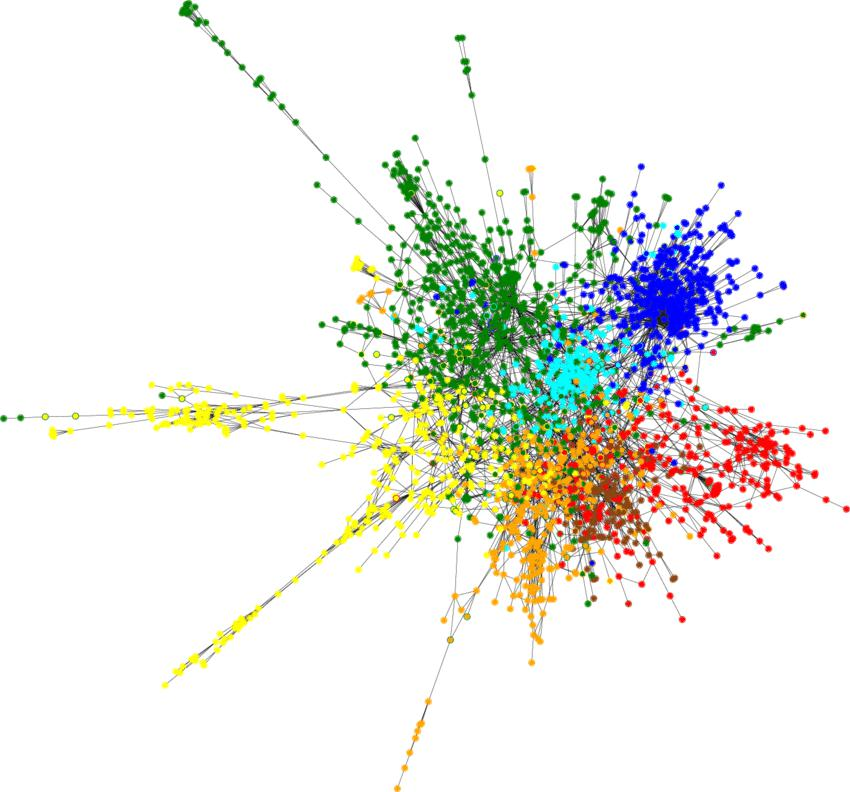

## Modelo

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

## Train

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)

# Definir la función de pérdida y el optimizador
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)





model.train()
for epoch in range(1000): #epoch
    optimizer.zero_grad()# Clear gradients
    out = model(data) # Forward pass
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # Calculate loss function
    loss.backward()# Compute gradients
    optimizer.step()# Tune parameters


    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f}' ) # | Acc: {acc*100:.2f}%')



Epoch   0 | Loss: 1.95
Epoch  50 | Loss: 1.39
Epoch 100 | Loss: 0.92
Epoch 150 | Loss: 0.76
Epoch 200 | Loss: 0.77
Epoch 250 | Loss: 0.67
Epoch 300 | Loss: 0.57
Epoch 350 | Loss: 0.60
Epoch 400 | Loss: 0.53
Epoch 450 | Loss: 0.52
Epoch 500 | Loss: 0.54
Epoch 550 | Loss: 0.60
Epoch 600 | Loss: 0.55
Epoch 650 | Loss: 0.59
Epoch 700 | Loss: 0.49
Epoch 750 | Loss: 0.52
Epoch 800 | Loss: 0.52
Epoch 850 | Loss: 0.61
Epoch 900 | Loss: 0.50
Epoch 950 | Loss: 0.50


## Evaluación

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8310
